In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
from pathlib import Path
import numpy as np
import datetime
import glob

dummy_date = "2000-01-01" # Dummy date to synchronize time axes (since only H:M:S is needed)

In [2]:
# Input folder name of the data you'd like to inspect
data_folder = "Cyclone Lab Data 20260209"

In [3]:
project_path = os.path.join(os.getcwd(), data_folder)

LS_data = os.listdir(os.path.join(project_path, "LS"))

HS_data = os.listdir(os.path.join(project_path, "HS"))

LS_data, HS_data

(['AnalogCMv00.SYN0901019FC1_LSDataLogger_20260209T090830+428.csv',
  'AnalogCMv00.SYN0901019FC1_LSDataLogger_20260209T101405+004.csv'],
 ['RawHS.SYN0901019FC1_Fs4000_T300_20260209T160006.csv',
  'RawHS.SYN0901019FC1_Fs4000_T300_20260209T160506.csv',
  'RawHS.SYN0901019FC1_Fs4000_T300_20260209T161006.csv',
  'RawHS.SYN0901019FC1_Fs4000_T300_20260209T161506.csv',
  'RawHS.SYN0901019FC1_Fs4000_T300_20260209T162006.csv',
  'RawHS.SYN0901019FC1_Fs4000_T300_20260209T162506.csv',
  'RawHS.SYN0901019FC1_Fs4000_T300_20260209T163006.csv',
  'RawHS.SYN0901019FC1_Fs4000_T300_20260209T163506.csv',
  'RawHS.SYN0901019FC1_Fs4000_T300_20260209T164006.csv',
  'RawHS.SYN0901019FC1_Fs4000_T300_20260209T164506.csv'])

In [4]:
# Concatinating LS data into full day set

LS_data_continuous = LS_data[:5] # take only the first 5 files, since they are continuous. The rest are separate tests

cols = ["Timestamp", "CL01Flow", "CL01Pressure", "CL01Density"]

dfs = []
for file in LS_data_continuous:
    df = pd.read_csv(Path(project_path) / "LS" / file, usecols=cols)
    dfs.append(df)

LS_whole_day_df = pd.concat(dfs, ignore_index=True)


# Extract hh:mm:ss from "Timestamp"
LS_whole_day_df["Timestamp"] = (
    LS_whole_day_df["Timestamp"]
    .astype(str)
    .str.extract(r"T(\d{6})", expand=False)
)


# convert to datetime.time only if not already in that format
if not isinstance(LS_whole_day_df["Timestamp"].iloc[0], datetime.time):
    LS_whole_day_df["Timestamp"] = pd.to_datetime(LS_whole_day_df["Timestamp"].astype(str).str.zfill(6), format="%H%M%S").dt.time

# --- LS timestamp prep ---
if LS_whole_day_df['Timestamp'].dtype == 'object':
    LS_whole_day_df['Timestamp'] = LS_whole_day_df['Timestamp'].astype(str)
    LS_whole_day_df['Timestamp'] = dummy_date + " " + LS_whole_day_df['Timestamp']
    LS_whole_day_df['Timestamp'] = pd.to_datetime(LS_whole_day_df['Timestamp'])
    LS_time_axis  = LS_whole_day_df["Timestamp"]

print(LS_whole_day_df.head())

print('')

# HS data
hs_folder = rf"{project_path}/HS"       # folder containing HS csv files
print(f"hs_folder path: {hs_folder}")

hs_files = sorted(glob.glob(os.path.join(hs_folder, "RawHS*.csv")))
print(f"hs_files: {hs_files}")

            Timestamp  CL01Pressure  CL01Flow  CL01Density
0 2000-01-01 09:08:32      0.512711  0.362560          0.0
1 2000-01-01 09:08:34      0.512711  0.318613          0.0
2 2000-01-01 09:08:36      0.512711  0.208747          0.0
3 2000-01-01 09:08:38      0.512711  0.384533          0.0
4 2000-01-01 09:08:41      0.512711  0.439467          0.0

hs_folder path: /home/Xillian/Documents/WEIR/India-test-lab/Cyclone Lab Data 20260209/HS
hs_files: ['/home/Xillian/Documents/WEIR/India-test-lab/Cyclone Lab Data 20260209/HS/RawHS.SYN0901019FC1_Fs4000_T300_20260209T160006.csv', '/home/Xillian/Documents/WEIR/India-test-lab/Cyclone Lab Data 20260209/HS/RawHS.SYN0901019FC1_Fs4000_T300_20260209T160506.csv', '/home/Xillian/Documents/WEIR/India-test-lab/Cyclone Lab Data 20260209/HS/RawHS.SYN0901019FC1_Fs4000_T300_20260209T161006.csv', '/home/Xillian/Documents/WEIR/India-test-lab/Cyclone Lab Data 20260209/HS/RawHS.SYN0901019FC1_Fs4000_T300_20260209T161506.csv', '/home/Xillian/Documents/WEIR/Ind

# Plotting

In [7]:
# Adjust these parameters if needed:

start_analysis_time = "16:00:00"  # first HS set for 11/02/2026
end_analysis_time   = "17:00:00"
# uncomment the relevant mdates.Locator depending on desired interval
x_axis_ticks_hrs = 1   # x hours
x_axis_ticks_min = 10  # y mins
x_axis_ticks_sec = 10  # z seconds

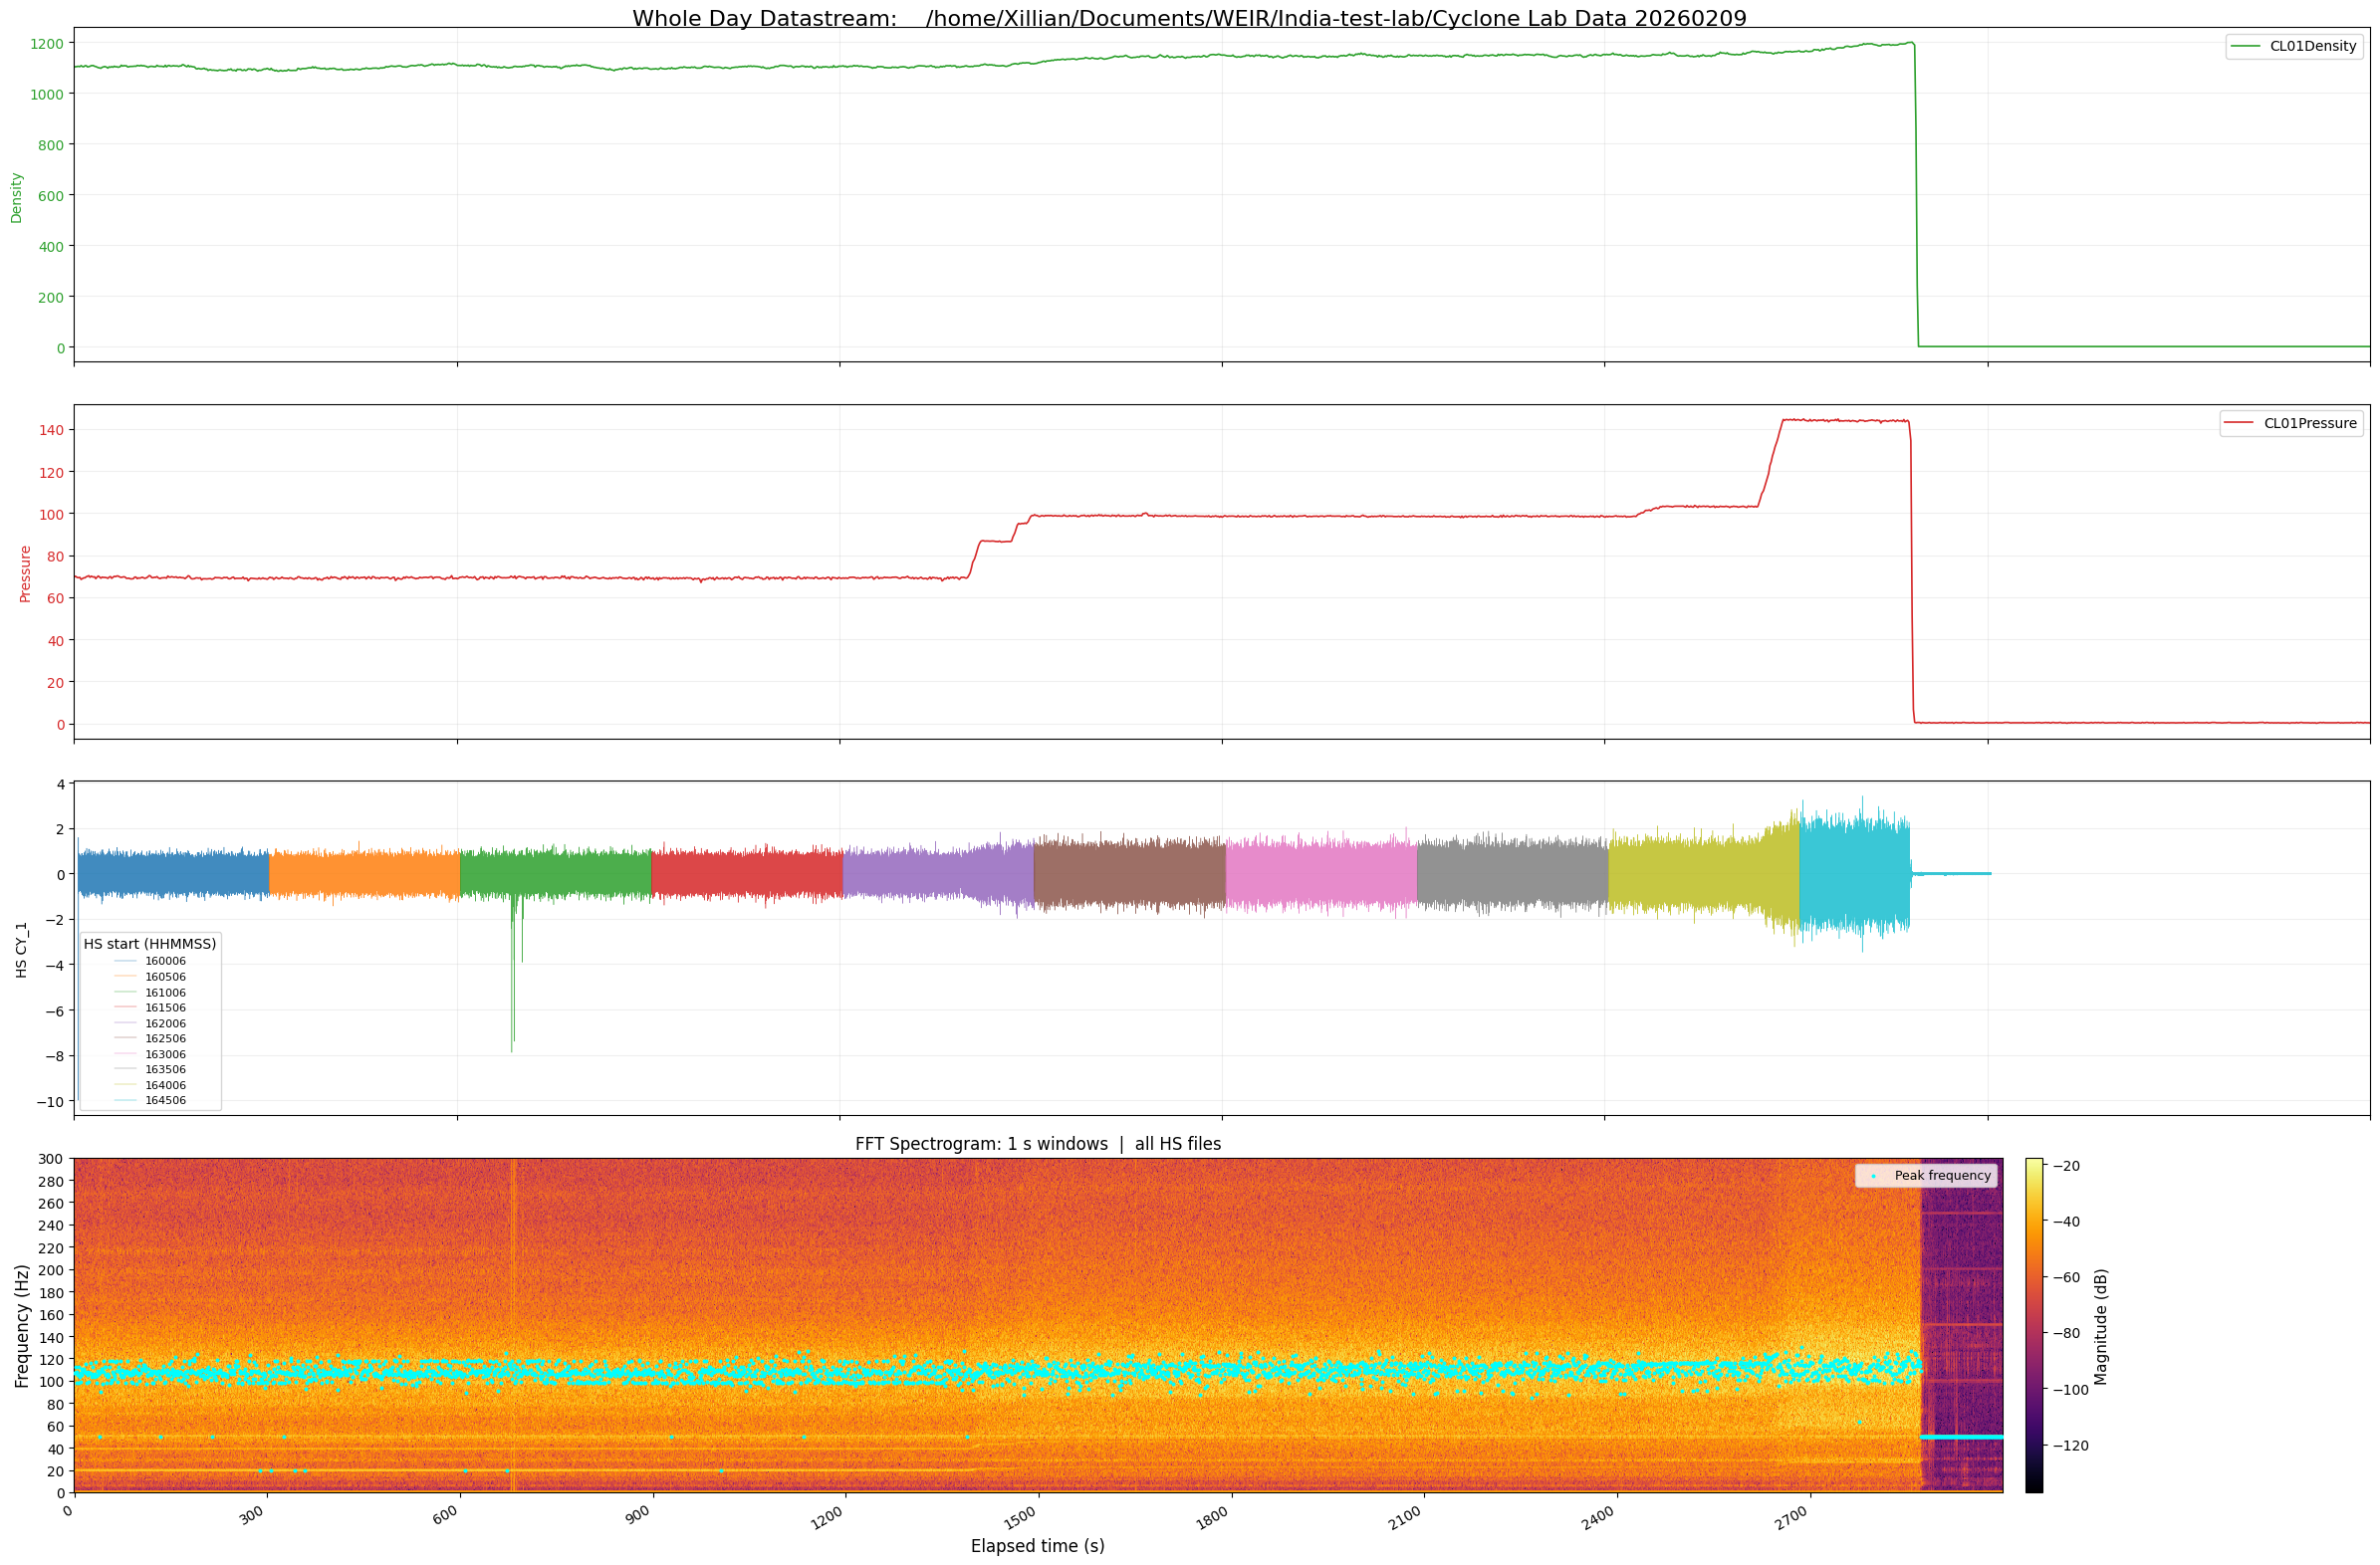

In [13]:
T_minutes = 5


# ── FFT Spectrogram Parameters ─────────────────────────────────────────────────
fs               = 4000   # Hz
samples_per_sec  = fs     # 4000 samples per 1-second window
USE_DB           = True   # False → linear magnitude
FREQ_MAX         = 300    # Hz — crop x-axis (None = full Nyquist)

fig, axes = plt.subplots(
    nrows=4, ncols=1,
    figsize=(24, 16),
    sharex=False,                                   # spectrogram has a different x-axis (freq, not time)
    gridspec_kw={"height_ratios": [1, 1, 1, 1]}
)
ax_dens, ax_press, ax_hs, ax_spec = axes



# ── Plot 1: Density ────────────────────────────────────────────────────────────
ax_dens.plot(LS_time_axis, LS_whole_day_df["CL01Density"],
             linewidth=1.2, color="tab:green", label="CL01Density")
ax_dens.set_ylabel("Density", color="tab:green")
ax_dens.tick_params(axis="y", labelcolor="tab:green")
ax_dens.grid(True, alpha=0.2)
ax_dens.legend(loc="upper right")



# ── Plot 2: Pressure ───────────────────────────────────────────────────────────
ax_press.plot(LS_time_axis, LS_whole_day_df["CL01Pressure"],
              linewidth=1.2, color="tab:red", label="CL01Pressure")
ax_press.set_ylabel("Pressure", color="tab:red")
ax_press.tick_params(axis="y", labelcolor="tab:red")
ax_press.grid(True, alpha=0.2)
ax_press.legend(loc="upper right")



# ── Plot 3: HS raw signal + build FFT data across all files ───────────────────
# Accumulate all HS data for the spectrogram, keyed by absolute second index
all_fft_rows   = []   # list of (start_second_abs, fft_row, peak_freq)
all_hs_seconds = []   # track absolute second boundaries per file for the colorbar

for hs_file_path in hs_files:
    hs_file = os.path.basename(hs_file_path)
    HS_df   = pd.read_csv(hs_file_path)
    cols    = [c for c in HS_df.columns if c.startswith("CY_1_T+")]
    if not cols:
        print(f"Skipping {hs_file}: no CY_1_T+ columns found")
        continue

    HS_df_conc = pd.concat([HS_df[c] for c in cols], ignore_index=True).to_frame("CY_1")
    # print(f"file: {hs_file} - found {len(cols)} CY_1_T+ columns, total {len(HS_df_conc)} rows after stacking")

    # Parse start time from filename
    try:
        hhmmss = hs_file.split("_T300")[1].split("T")[1][:6]
        # print(f"Checking HS TimeStamp is correct: {hs_file, hhmmss}")
        # print('')
    except Exception:
        print(f"Skipping {hs_file}: couldn't parse time from filename")
        continue

    hs_start_time = pd.to_datetime(hhmmss, format="%H%M%S").replace(year=2000, month=1, day=1)
    hs_end_time   = hs_start_time + pd.Timedelta(minutes=T_minutes)
    hs_time_axis  = pd.date_range(start=hs_start_time, end=hs_end_time,
                                  periods=HS_df_conc.shape[0])



    # ── Raw signal plot ────────────────────────────────────────────────────────
    ax_hs.plot(hs_time_axis, HS_df_conc["CY_1"],
               linewidth=0.35, alpha=0.85, label=hhmmss)

    # ── FFT per 1-second window ────────────────────────────────────────────────
    signal    = HS_df_conc["CY_1"].values
    n_samples = len(signal)
    n_seconds = int(n_samples / samples_per_sec)
    n_freqs   = samples_per_sec // 2 + 1

    for t in range(n_seconds):
        start  = t * samples_per_sec
        end    = start + samples_per_sec
        window = signal[start:end]
        N      = len(window)

        hann    = np.hanning(N)
        fft_out = np.fft.rfft(window * hann)
        mag     = np.abs(fft_out) / N

        # Absolute second from midnight for the time axis
        abs_second = hs_start_time + pd.Timedelta(seconds=t)

        peak_bin  = np.argmax(mag[1:]) + 1
        peak_freq = peak_bin * (fs / N)

        all_fft_rows.append({
            "abs_second": abs_second,
            "mag":        mag,
            "peak_freq":  peak_freq,
        })


# ── Assemble spectrogram matrix ────────────────────────────────────────────────
if all_fft_rows:
    # Sort rows chronologically
    all_fft_rows.sort(key=lambda r: r["abs_second"])

    fft_matrix  = np.array([r["mag"]        for r in all_fft_rows])   # (n_windows, n_freqs)
    peak_freqs  = np.array([r["peak_freq"]  for r in all_fft_rows])
    time_labels = [r["abs_second"]          for r in all_fft_rows]    # datetime per row
    time_secs   = [(t - time_labels[0]).total_seconds() for t in time_labels]

    # Frequency axis
    freq_axis = np.fft.rfftfreq(samples_per_sec, d=1 / fs)

    # Crop to FREQ_MAX
    if FREQ_MAX is not None:
        freq_mask  = freq_axis <= FREQ_MAX
        freq_plot  = freq_axis[freq_mask]
        mat_plot   = fft_matrix[:, freq_mask]
    else:
        freq_plot  = freq_axis
        mat_plot   = fft_matrix

    if USE_DB:
        mat_plot   = 20 * np.log10(mat_plot + 1e-12)
        cbar_label = "Magnitude (dB)"
    else:
        cbar_label = "Magnitude"

    # ── Plot 4: Spectrogram ────────────────────────────────────────────
    # x = frequency, y = time (seconds elapsed from first window)
    im = ax_spec.pcolormesh(
        np.array(time_secs),
        freq_plot,
        mat_plot.T,
        shading="auto",
        cmap="inferno"
    )
    cbar = fig.colorbar(im, ax=ax_spec, pad=0.01)
    cbar.set_label(cbar_label, fontsize=11)

    # Overlay peak frequency per window
    ax_spec.scatter(np.array(time_secs), peak_freqs,
                    color="cyan", s=8, linewidths=0,
                    label="Peak frequency", zorder=3)

    ax_spec.set_xlabel("Elapsed time (s)", fontsize=12)
    ax_spec.set_ylabel("Frequency (Hz)", fontsize=12)
    ax_spec.set_title("FFT Spectrogram: 1 s windows  |  all HS files", fontsize=12)
    ax_spec.set_ylim(0, freq_plot[-1])
    ax_spec.set_yticks(np.arange(0, FREQ_MAX + 1, 20))
    ax_spec.set_xticks(np.arange(0, max(time_secs) + 1, 300))
    ax_spec.legend(loc="upper right", fontsize=9)
    ax_spec.grid(False)

    # Optional: annotate file boundaries with horizontal lines
    elapsed = 0
    for hs_file_path in hs_files:
        hs_file = os.path.basename(hs_file_path)
        try:
            hhmmss     = hs_file.split("_T300")[1].split("T")[1][:6]
            hs_start   = pd.to_datetime(hhmmss, format="%H%M%S").replace(year=2000, month=1, day=1)
            file_start = (hs_start - time_labels[0]).total_seconds()
            ax_spec.axhline(file_start, color="white", linewidth=0.6,
                            linestyle="--", alpha=0.5)
        except Exception:
            pass

# ── HS axis formatting ─────────────────────────────────────────────────────────
ax_hs.set_ylabel("HS CY_1")
ax_hs.set_xlabel("Time")
ax_hs.grid(True, alpha=0.2)

if len(hs_files) <= 12:
    ax_hs.legend(title="HS start (HHMMSS)", loc="lower left", fontsize=8)

ax_hs.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M:%S"))
ax_hs.set_xlim(
    pd.to_datetime(start_analysis_time, format="%H:%M:%S").replace(year=2000, month=1, day=1),
    pd.to_datetime(end_analysis_time,   format="%H:%M:%S").replace(year=2000, month=1, day=1)
)
ax_hs.xaxis.set_major_locator(mdates.MinuteLocator(interval=x_axis_ticks_min))
# ax_hs.xaxis.set_major_locator(mdates.HourLocator(interval=x_axis_ticks_hrs))
# ax_hs.xaxis.set_major_locator(mdates.SecondLocator(interval=x_axis_ticks_sec))

# Apply date formatting only to the time-axis subplots (not the spectrogram)
for ax in [ax_dens, ax_press, ax_hs]:
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M:%S"))
    ax.set_xlim(
        pd.to_datetime(start_analysis_time, format="%H:%M:%S").replace(year=2000, month=1, day=1),
        pd.to_datetime(end_analysis_time,   format="%H:%M:%S").replace(year=2000, month=1, day=1)
    )
    ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=x_axis_ticks_min))

fig.autofmt_xdate()
fig.suptitle(f"Whole Day Datastream:    {project_path}", fontsize=16)
plt.tight_layout()
plt.show()